# Smoke Detection
Data taken from https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset?resource=download

In [1]:
import sys
import pandas as pd
import numpy as np
import torch
from torch import distributions
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
from copy import deepcopy
# setting path
sys.path.append('..')
from functions.np_classifier_torch import cutoff_bin, power_alpha_calc  # noqa: E402
from functions.estimators_torch import kliep_multi_dim_sep_wrap, kliep_multi_dim_naive_sep_wrap, kliep_miss_wrap  # noqa: E402
from functions.estimators_torch import kliep_multi_dim_imp_wrap, kliep_multi_dim_sep_imp_wrap  # noqa: E402
from functions.objective_funcs_torch import get_dat_vals_impute, get_dat_vals_multidim
from functions.pipeline_funcs import missing_pipeline, full_pipeline, get_ci, progress, create_standard_miss_func  # noqa: E402

plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["savefig.facecolor"] = "White"
plt.rc('font',**{'family':'sans-serif', 'size': 14})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
page_width=9
width_height_ratio=3/4

unif=distributions.Uniform(0,1)

Perform basic data manipulation

In [6]:
# Read in data
df = pd.read_csv("../real_world_data/smoke_detection_iot.csv", index_col=0,header=0)

# Fix data
df["TVOC[ppb]"] = np.where(df["TVOC[ppb]"]<1000,df["TVOC[ppb]"],1000)
df["eCO2[ppm]"] = np.where(df["eCO2[ppm]"]<1000,df["eCO2[ppm]"],1000)
df["PM1.0"] = np.where(df["PM1.0"]<1,df["PM1.0"], 1)
df["PM2.5"] = np.where(df["PM2.5"]<1,df["PM2.5"], 1)
df["NC0.5"] = np.where(df["NC0.5"]<5,df["NC0.5"], 5)
df["NC2.5"] = np.where(df["NC2.5"]<5,df["PM2.5"], 5)

df.drop(["CNT","UTC"],axis=1,inplace=True)
# Fix 
df_fin = df
df_fin_nodrop=df_fin.drop("Fire Alarm",axis=1)
null_df = df_fin[df_fin["Fire Alarm"]==1].drop("Fire Alarm",axis=1)
alt_df = df_fin[df_fin["Fire Alarm"]==0].drop("Fire Alarm", axis=1)

# Get normalisation terms from training tensor
std = np.std(df_fin_nodrop.to_numpy(), axis=0)
m = np.mean(df_fin_nodrop.to_numpy(), axis=0)

dim = df_fin_nodrop.shape[1]

Run 1 simulation of each approach

In [8]:
# def our_f(x):
#     return torch.concat([x,x**2],dim=1)
def our_f(x):
    return x


lr = (0.7**(np.floor((np.arange(10000)+2)/100)))
maxiter = 1000
tol=1e-3
reg=0
new_seed=12348

torch.manual_seed(new_seed)
# ### Seed Setting ### #
split_seed=int(1e9*unif.sample([1])[0])
miss_seed=int(1e9*unif.sample([1])[0])
learn_seed=int(1e9*unif.sample([1])[0])
new_seed = int(1e9*unif.sample([1])[0])
# ### Chossing missing functions ### #
signs = torch.tensor([-1., 1.])
signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=df_fin_nodrop.shape[1],
                                replacement=True)]
missing_funcs = [create_standard_miss_func(
    m[j], std[j], -signs[j]) for j in range(df_fin_nodrop.shape[1])]
# Test our method

temp_our = full_pipeline(
    null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
    est_miss=True, lr=lr, alpha=0.1, delta=0.05, nlearn=50, 
    reg=reg, maxiter=maxiter, tol=tol, f=our_f,
    split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)

# Test true method
temp_true = full_pipeline(
    null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
    est_miss=False, lr=lr, f=our_f,
    alpha=0.1, delta=0.05, reg=reg, maxiter=maxiter, tol=tol,
    split_seed=split_seed, miss_seed=miss_seed)

# Test naive method
temp_naive = full_pipeline(
    null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
    dr_proc=kliep_multi_dim_naive_sep_wrap,
    est_miss=False, lr=lr, f=our_f,
    alpha=0.1, delta=0.05, reg=reg, maxiter=maxiter, tol=tol,
    split_seed=split_seed, miss_seed=miss_seed)

# Test no missing ability
temp_nomiss_norm = full_pipeline(
    null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
    dr_proc=kliep_miss_wrap, dat_val_fun=get_dat_vals_impute,
    est_miss=False, lr=lr, f=our_f,
    alpha=0.1, delta=0.05, reg=reg, maxiter=maxiter, tol=tol,
    split_seed=split_seed)

# Test no missing with NB approach
temp_nomiss_nb = full_pipeline(
    null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
    est_miss=False, lr=lr,  f=our_f,
    alpha=0.1, delta=0.05, maxiter=maxiter,
    split_seed=split_seed)

Now give the results

In [9]:
print(temp_nomiss_norm["power_res"])
print(temp_nomiss_nb["power_res"])
print(temp_our["power_res"])
print(temp_naive["power_res"])
print(temp_true["power_res"])

[[tensor(0.7878), tensor(0.0969)]]
[[tensor(0.6898), tensor(0.0969)]]
[[tensor(0.6918), tensor(0.0969)]]
[[tensor(0.5424), tensor(0.0969)]]
[[tensor(0.6890), tensor(0.0969)]]


# Vary Alpha
Now we repeat the process for varying $\alpha$

In [18]:
warnings.filterwarnings("ignore")
alphas = [0.3,0.25,0.2,0.15,0.1,0.05]
deltas = [0.05]*len(alphas)

true_meth = []
best_meth = []
naive_meth = []
nomiss_nb_meth = []
nomiss_norm_meth = []
mice_meth = []
new_seed=12344
reg=0
tol=1e-3
maxiter=int(1e3)
mice_args = {"sample_posterior": False, "n_nearest_features": 9}  

nsim=100
for i in range(nsim):
    torch.manual_seed(new_seed)
    # ### Seed Setting ### #
    split_seed=int(1e9*unif.sample([1])[0])
    miss_seed=int(1e9*unif.sample([1])[0])
    learn_seed=int(1e9*unif.sample([1])[0])
    new_seed = int(1e9*unif.sample([1])[0])
    # ### Chossing missing functions ### #
    signs = torch.tensor([-1., 1.])
    signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=df_fin_nodrop.shape[1],
                                    replacement=True)]
    missing_funcs = [create_standard_miss_func(
        m[j], std[j], -signs[j]) for j in range(df_fin_nodrop.shape[1])]
    # Test our method
    temp_our = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
        est_miss=True, lr=lr, alpha=alphas, delta=deltas, nlearn=50, 
        reg=reg, maxiter=maxiter, tol=tol,
        split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
    best_meth.append(temp_our["power_res"])

    # Test true method
    temp_true = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
        est_miss=False, lr=lr,
        alpha=alphas, delta=deltas, reg=reg, maxiter=maxiter, tol=tol,
        split_seed=split_seed, miss_seed=miss_seed)
    true_meth.append(temp_true["power_res"])

    # Test naive method
    temp_naive = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
        dr_proc=kliep_multi_dim_naive_sep_wrap,
        est_miss=False, lr=lr,
        alpha=alphas, delta=deltas, reg=reg, maxiter=maxiter, tol=tol,
        split_seed=split_seed, miss_seed=miss_seed)
    naive_meth.append(temp_naive["power_res"])

    # Test no missing ability
    temp_nomiss_norm = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        dr_proc=kliep_miss_wrap, dat_val_fun=get_dat_vals_impute,
        est_miss=False, lr=lr,
        alpha=alphas, delta=deltas, reg=reg, maxiter=maxiter, tol=tol,
        split_seed=split_seed)
    nomiss_norm_meth.append(temp_nomiss_norm["power_res"])
   
   # Test no missing with NB approach
    temp_nomiss_nb = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        est_miss=False, lr=lr, alpha=alphas, delta=deltas, maxiter=maxiter,
        split_seed=split_seed)
    nomiss_nb_meth.append(temp_nomiss_nb["power_res"])
    progress(int(100*(i+1)/nsim))

    temp_mice = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=5000, n_nulltr=20000,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", opt_type="Scalar",
        mice_args=mice_args, est_miss=False, lr=lr, alpha=alphas,
        delta=deltas, maxiter=maxiter,
        split_seed=split_seed, miss_seed=miss_seed)
    mice_meth.append(temp_mice["power_res"])


results = {"Learning Missingness Func": best_meth, "Naive": naive_meth,
 "Known Missingness Func": true_meth, "No Missing NB": nomiss_nb_meth,
 "No Missing Normal": nomiss_norm_meth, "MICE": mice_meth}

data = (results,{"alphas": alphas, "deltas": deltas})

with open('../results/real_world_results/smokedetect_fullrand_'+str(nsim)+'sim_allmeth_varyalpha.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

[########################################]100%

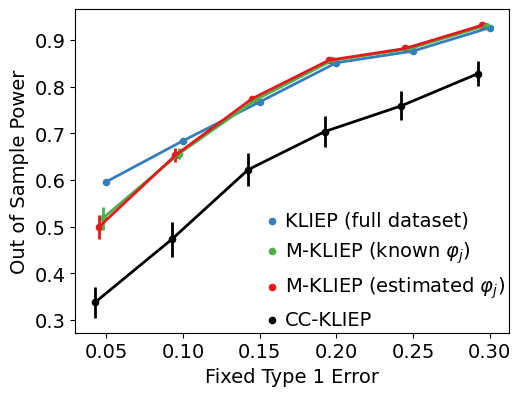

In [2]:
with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_varyalpha.pkl', 'rb') as handle:
    results, params = pickle.load(handle)
    
names = {
    "No Missing NB": "KLIEP (full dataset)",
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$)",
    "Naive": "CC-KLIEP"
}

cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000',u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = np.array(params["alphas"])
    all_cis = get_ci(torch.tensor(results[key])[:, :, 0],
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff=x[1]-x[0]
    x_jit=x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i])
    ax.errorbar(x_jit, y, error, c=cs[i], linewidth=2)

ax.set(xlabel="Fixed Type 1 Error", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)


plt.savefig("../plots/np_RWE_smoke_varyalpha.pdf",bbox_inches="tight", dpi=300)

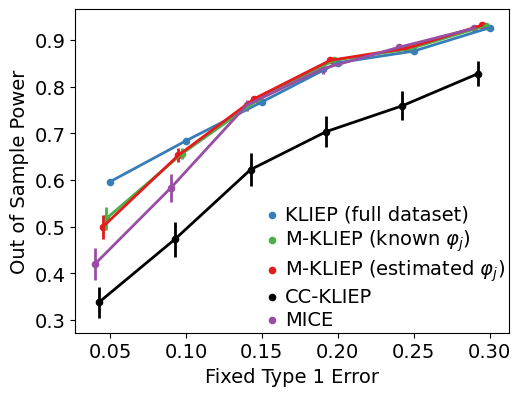

In [3]:
with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_varyalpha.pkl', 'rb') as handle:
    results, params = pickle.load(handle)
    
names = {
    "No Missing NB": "KLIEP (full dataset)",
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$)",
    "Naive": "CC-KLIEP",
    "MICE": "MICE"
}

cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000',u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = np.array(params["alphas"])
    all_cis = get_ci(torch.tensor(results[key])[:, :, 0],
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff=x[1]-x[0]
    x_jit=x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i])
    ax.errorbar(x_jit, y, error, c=cs[i], linewidth=2)

ax.set(xlabel="Fixed Type 1 Error", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False,labelspacing=0.2)


plt.savefig("../plots/np_RWE_smoke_varyalpha_mice.pdf",bbox_inches="tight", dpi=300)

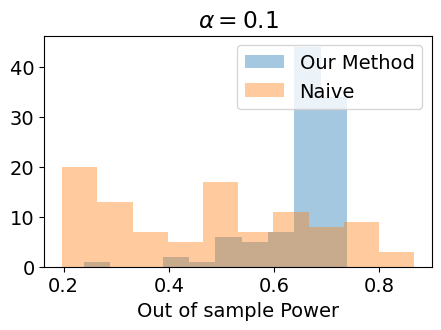

In [4]:
results_our = np.array(results["Learning Missingness Func"])[:,4,0]
results_naive = np.array(results["Naive"])[:,4,0]

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(results_our, alpha=0.4, label='Our Method')
ax.hist(results_naive, alpha=0.4, label='Naive')
ax.legend(loc='upper right')
ax.set(title=r"$\alpha=$"+str(params["alphas"][4]),xlabel="Out of sample Power")


plt.savefig("../plots/np_RWE_smoke_power_dist.pdf",bbox_inches="tight")

# Vary $\varphi$ to vary Proportion Missing
We vary $a_{j,0}$ to vary the proportion of points missing. We now work out what $a_{j,0}$ ti choose to give our desired missing proportions

In [20]:
def miss_prop_opt(loc,data, m, std, sign, target_prop):
    varphi = create_standard_miss_func(m,std, sign,loc)
    return (torch.nanmean(varphi(data))-target_prop)**2


df_tens = torch.tensor(
    (df_fin_nodrop).to_numpy().astype(np.float32))

locs = []
miss_props = np.arange(0.1,1,0.1)
for i, miss_prop in enumerate(miss_props):
    temp_locs = []
    for j in range(df_fin_nodrop.shape[1]):
        opt_plus = optimize.minimize_scalar(
            miss_prop_opt,args=(df_tens[:,j],m[j],std[j],1.,miss_prop))
        opt_minus = optimize.minimize_scalar(
            miss_prop_opt,args=(df_tens[:,j],m[j],std[j],-1.,miss_prop))
    
        temp_locs.append([opt_plus["x"], opt_minus["x"]])
    locs.append(temp_locs)
    progress(int(100*(i+1)/miss_props.shape[0]))

[########################################]100%

We now perform our procedure for these various missing proportions

In [21]:
warnings.filterwarnings("ignore")
new_seed = 12345
reg = 0
alphas = 0.1
deltas = 0.05
nsim = 100
miss_props = np.arange(0.1,1,0.1)
true_meth = {
    key: [[] for j in range(miss_props.shape[0])]
    for key in ["power_res", "prop_miss", "true_prop_miss"]
}
lr = 0.7**(np.floor((np.arange(1000))/100)+1)

best_meth = deepcopy(true_meth)
naive_meth = deepcopy(true_meth)
mice_meth = deepcopy(true_meth)

for j, miss_prop in enumerate(miss_props):
    for i in range(nsim):
        torch.manual_seed(new_seed)
        # ### Seed Setting ### #
        split_seed = int(1e9*unif.sample([1])[0])
        miss_seed = int(1e9*unif.sample([1])[0])
        learn_seed = int(1e9*unif.sample([1])[0])
        new_seed = int(1e9*unif.sample([1])[0])

        # ### Chossing missing functions ### #
        signs = torch.tensor([-1., 1.])
        signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=df_fin_nodrop.shape[1],
                                        replacement=True)]

        sign_locs = ((signs+1)/2).int()
        missing_funcs = [create_standard_miss_func(
            m[l], std[l], -signs[l], shift=locs[j][l][sign_locs[l]])
            for l in range(df_fin_nodrop.shape[1])]

        # Test our method
        temp_our = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
            est_miss=True, alpha=alphas, delta=deltas, nlearn=10, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
        best_meth["power_res"][j].append(temp_our["power_res"][0])
        best_meth["prop_miss"][j].append(temp_our["prop_miss"])
        best_meth["true_prop_miss"][j].append(miss_prop)

        # Test true method
        temp_true = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
            est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed)
        true_meth["power_res"][j].append(temp_true["power_res"][0])
        true_meth["prop_miss"][j].append(temp_true["prop_miss"])
        true_meth["true_prop_miss"][j].append(miss_prop)

        # Test naive method
        temp_naive = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=5000, n_nulltr=20000,
            dr_proc=kliep_multi_dim_naive_sep_wrap,
            est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed)
        naive_meth["power_res"][j].append(temp_naive["power_res"][0])
        naive_meth["prop_miss"][j].append(temp_naive["prop_miss"])
        naive_meth["true_prop_miss"][j].append(miss_prop)

        # Test mice method
        temp_mice = full_pipeline(
            null_df, alt_df, missing_funcs=missing_funcs, n_altte=5000, n_nulltr=20000,
            dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", opt_type="Scalar",
            mice_args=mice_args, est_miss=False, lr=lr, alpha=alphas,
            delta=deltas, maxiter=100,
            split_seed=split_seed, miss_seed=miss_seed)
        mice_meth["power_res"][j].append(temp_mice["power_res"][0])
        mice_meth["prop_miss"][j].append(temp_mice["prop_miss"])
        mice_meth["true_prop_miss"][j].append(miss_prop)

        progress(int(100*(j*nsim+(i+1))/(nsim*miss_props.shape[0])))

results = {
    "Learning Missingness Func": best_meth,
    "Naive": naive_meth, "Known Missingness Func": true_meth,
    "MICE": mice_meth
}

data = (results, {"alphas": alphas, "deltas": deltas})
with open('../results/real_world_results/smokedetect_fullrand_'+str(nsim)+'sim_allmeth_varymissfixed_scalar.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


[########################################]100%

Finally perform each procedure with no-mising data (with no missing data each procedure is the same.)

In [22]:
new_seed = 12345
reg = 0
alphas = 0.1
deltas = 0.05
nsim = 100
true_meth = {
    key: [[]]
    for key in ["power_res", "prop_miss", "true_prop_miss"]
}
lr = 0.7**(np.floor((np.arange(1000))/100)+1)

best_meth = deepcopy(true_meth)
naive_meth = deepcopy(true_meth)
mice_meth = deepcopy(true_meth)
miss_prop=0
for i in range(nsim):
    torch.manual_seed(new_seed)
    # ### Seed Setting ### #
    split_seed = int(1e9*unif.sample([1])[0])
    miss_seed = int(1e9*unif.sample([1])[0])
    learn_seed = int(1e9*unif.sample([1])[0])
    new_seed = int(1e9*unif.sample([1])[0])

    # ### Chossing missing functions ### #
    signs = torch.tensor([-1., 1.])
    signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=df_fin_nodrop.shape[1],
                                    replacement=True)]

    sign_locs = ((signs+1)/2).int()
    missing_funcs = [create_standard_miss_func(
        m[l], std[l], -signs[l], shift=locs[j][l][sign_locs[l]])
        for l in range(df_fin_nodrop.shape[1])]

    # Test our method
    temp_our = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        est_miss=False, alpha=alphas, delta=deltas, nlearn=10, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
    best_meth["power_res"][0].append(temp_our["power_res"][0])
    best_meth["prop_miss"][0].append(0)
    best_meth["true_prop_miss"][0].append(miss_prop)

    # Test true method
    temp_true = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed)
    true_meth["power_res"][0].append(temp_true["power_res"][0])
    true_meth["prop_miss"][0].append(0)
    true_meth["true_prop_miss"][0].append(miss_prop)

    # Test naive method
    temp_naive = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        impute=None, est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed)
    naive_meth["power_res"][0].append(temp_naive["power_res"][0])
    naive_meth["prop_miss"][0].append(0)
    naive_meth["true_prop_miss"][0].append(miss_prop)

    temp_mice = full_pipeline(
        null_df, alt_df, None, n_altte=5000, n_nulltr=20000,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", opt_type="Scalar",
        est_miss=False, lr=lr, alpha=alphas,
        delta=deltas, maxiter=100,
        split_seed=split_seed, miss_seed=miss_seed)
    mice_meth["power_res"][0].append(temp_mice["power_res"][0])
    mice_meth["prop_miss"][0].append(0)
    mice_meth["true_prop_miss"][0].append(miss_prop)

    progress(int(100*(i+1)/nsim))

results = {
    "Learning Missingness Func": best_meth,
    "Naive": naive_meth, "Known Missingness Func": true_meth,
    "MICE": mice_meth
}

data = (results, {"alphas": alphas, "deltas": deltas})
with open('../results/real_world_results/smokedetect_fullrand_'+str(nsim)+'sim_allmeth_nomiss_scalar.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


[########################################]100%

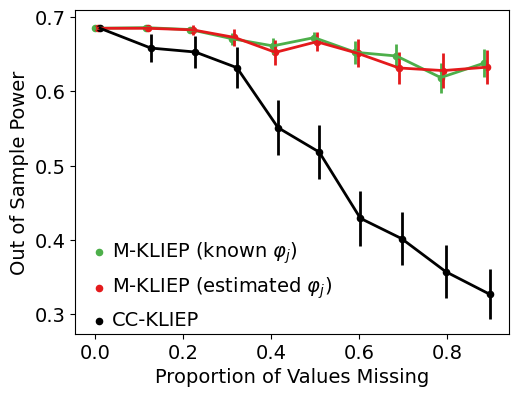

In [5]:
cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000',u'#984ea3']
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))

with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_nomiss_scalar.pkl', 'rb') as handle:
    no_miss_results, params = pickle.load(handle)

with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_varymissfixed_scalar.pkl', 'rb') as handle:
    results, params = pickle.load(handle)
names = {
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$) ",
    "Naive": "CC-KLIEP",
}
for i, key in enumerate(names):
    x = torch.mean(torch.tensor(no_miss_results[key]["prop_miss"]+results[key]["prop_miss"]),dim=1)
    all_cis = get_ci(torch.tensor(no_miss_results[key]["power_res"]+results[key]["power_res"])[:, :, 0].T,
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i+1])
    ax.errorbar(x_jit, y, error, c=cs[i+1],linewidth=2)

ax.set(xlabel="Proportion of Values Missing", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2, frameon=False)


plt.savefig("../plots/np_RWE_smoke_varymissfixed.pdf",
            bbox_inches="tight", dpi=300)

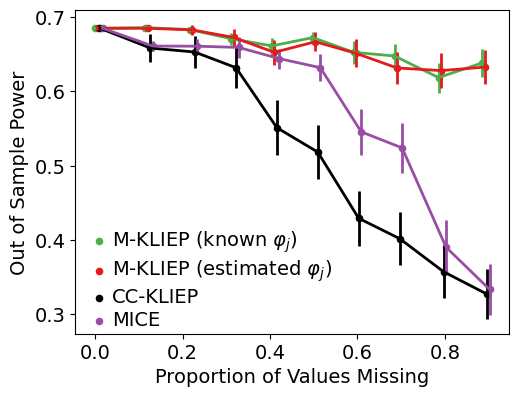

In [6]:
cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000',u'#984ea3']
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))

with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_nomiss_scalar.pkl', 'rb') as handle:
    no_miss_results, params = pickle.load(handle)

with open('../results/real_world_results/smokedetect_fullrand_100sim_allmeth_varymissfixed_scalar.pkl', 'rb') as handle:
    results, params = pickle.load(handle)
names = {
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$) ",
    "Naive": "CC-KLIEP",
    "MICE": "MICE"
}
for i, key in enumerate(names):
    x = torch.mean(torch.tensor(no_miss_results[key]["prop_miss"]+results[key]["prop_miss"]),dim=1)
    all_cis = get_ci(torch.tensor(no_miss_results[key]["power_res"]+results[key]["power_res"])[:, :, 0].T,
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i+1])
    ax.errorbar(x_jit, y, error, c=cs[i+1],linewidth=2)

ax.set(xlabel="Proportion of Values Missing", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2, frameon=False, labelspacing=0.2)

plt.savefig("../plots/np_RWE_smoke_varymissfixed_mice.pdf",
            bbox_inches="tight", dpi=300)